# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups          
Sample_057  Q5BLP8;Q5BLP8-2;Q5BLP8-3   19.227
Sample_156  Q13228;Q13228-4            17.504
Sample_167  P80748                     19.371
Sample_018  P36871;P36871-2            15.946
Sample_193  P02765                     23.721
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups
Sample_121  Q9H4D0           15.765
Sample_059  P01601           16.752
Sample_177  Q9NSB4           17.183
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.468
            A0A075B6Q5                 13.308
            A0A075B6R2                 11.736
            A0A075B6S5                 12.069
            A0A087WSY4                 13.299
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.839
            Q9UI40;Q9UI40-2            12.879
            Q9UIW2                     12.792
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.266
            Q9UP79                     13.555
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.218,15.050,16.842,19.863,15.754,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.629,19.067,...,15.528,15.576,14.270,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.787,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.758,17.705,17.039,16.168,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.515,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.217,15.345,17.084,18.708,14.249,19.433,12.116,11.210
Sample_207,15.739,16.877,15.469,16.898,15.001,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.159,13.777,12.640,12.489,13.610,12.832,12.033,11.305,12.727,12.746
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.537,19.067,16.127,...,10.830,14.386,11.364,13.451,11.817,13.663,12.653,12.576,13.234,12.766
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,13.672,12.815,13.203,12.465,11.195,13.141,12.695,13.647,11.638,12.753
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.398,12.298,13.608,12.549,12.974,13.272,12.898,12.061,12.881,13.489
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,12.166,13.003,12.466,12.482,13.264,13.554,13.258,13.447,12.497,13.010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.012,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 362.73it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.68it/s]

100%|██████████| 2/2 [00:00<00:00,  5.65it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.53it/s]

100%|██████████| 3/3 [00:00<00:00,  3.98it/s]

100%|██████████| 3/3 [00:00<00:00,  4.20it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.05it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.63it/s]

100%|██████████| 4/4 [00:00<00:00,  4.80it/s]

100%|██████████| 4/4 [00:00<00:00,  5.25it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.47it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.74it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.62it/s]

100%|██████████| 5/5 [00:01<00:00,  3.66it/s]

100%|██████████| 5/5 [00:01<00:00,  3.81it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  8.28it/s]

 50%|█████     | 3/6 [00:00<00:00,  6.22it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  5.31it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  4.40it/s]

100%|██████████| 6/6 [00:01<00:00,  3.73it/s]

100%|██████████| 6/6 [00:01<00:00,  4.44it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.46it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.64it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.40it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.94it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.11it/s]

100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

100%|██████████| 7/7 [00:01<00:00,  4.29it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.47it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.13it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.51it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.31it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.25it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  3.26it/s]

100%|██████████| 8/8 [00:02<00:00,  3.41it/s]

100%|██████████| 8/8 [00:02<00:00,  3.52it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.84it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.41it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.84it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.49it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.46it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.46it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.59it/s]

100%|██████████| 9/9 [00:03<00:00,  2.79it/s]

100%|██████████| 9/9 [00:03<00:00,  2.78it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.26it/s]

 30%|███       | 3/10 [00:00<00:01,  4.87it/s]

 40%|████      | 4/10 [00:00<00:01,  4.49it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.24it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.28it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.30it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.12it/s]

 90%|█████████ | 9/10 [00:02<00:00,  4.37it/s]

100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.12it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.84it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.28it/s]

 45%|████▌     | 5/11 [00:00<00:01,  5.10it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  5.00it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.59it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  5.00it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  5.38it/s]

 91%|█████████ | 10/11 [00:01<00:00,  5.17it/s]

100%|██████████| 11/11 [00:02<00:00,  5.00it/s]

100%|██████████| 11/11 [00:02<00:00,  5.19it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.86it/s]

 25%|██▌       | 3/12 [00:00<00:01,  6.55it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.34it/s]

 42%|████▏     | 5/12 [00:00<00:01,  5.22it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.93it/s]

 58%|█████▊    | 7/12 [00:01<00:00,  5.19it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  5.13it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  5.02it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  4.88it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.98it/s]

100%|██████████| 12/12 [00:02<00:00,  5.05it/s]

100%|██████████| 12/12 [00:02<00:00,  5.25it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  9.05it/s]

 23%|██▎       | 3/13 [00:00<00:01,  6.38it/s]

 31%|███       | 4/13 [00:00<00:01,  5.70it/s]

 38%|███▊      | 5/13 [00:00<00:01,  5.36it/s]

 46%|████▌     | 6/13 [00:01<00:01,  5.12it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.97it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.48it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.61it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  4.66it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.30it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.15it/s]

100%|██████████| 13/13 [00:02<00:00,  4.31it/s]

100%|██████████| 13/13 [00:02<00:00,  4.79it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.53it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.16it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.44it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.20it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.17it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.91it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.20it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.47it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.67it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.46it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.61it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.81it/s]

100%|██████████| 14/14 [00:03<00:00,  3.91it/s]

100%|██████████| 14/14 [00:03<00:00,  3.61it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  8.49it/s]

 20%|██        | 3/15 [00:00<00:01,  6.13it/s]

 27%|██▋       | 4/15 [00:00<00:02,  5.49it/s]

 33%|███▎      | 5/15 [00:00<00:02,  4.89it/s]

 40%|████      | 6/15 [00:01<00:02,  3.96it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.51it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.14it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.78it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  2.87it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.03it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.11it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.41it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.57it/s]

100%|██████████| 15/15 [00:04<00:00,  3.78it/s]

100%|██████████| 15/15 [00:04<00:00,  3.67it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.044 0.016          0.696 0.392       0.100   
2             0.006 0.006      0.054 0.022          0.711 0.091       0.599   
3             0.004 0.004      0.052 0.018          0.767 0.109       0.632   
4             0.004 0.005      0.042 0.014          0.715 0.095       0.681   
5             0.005 0.003      0.049 0.018          0.787 0.092       0.810   
6             0.006 0.006      0.053 0.020          0.785 0.091       0.814   
7             0.004 0.003      0.041 0.011          0.813 0.086       0.820   
8             0.006 0.006      0.063 0.021          0.818 0.087       0.823   
9             0.006 0.004      0.057 0.021          0.813 0.079       0.830   
10            0.004 0.003      0.037 0.009          0.809 0.082       0.831   
11            0.003 0.001      0.033 0.006          0.814 0.077       0.824   
12            0.004 0.001      0.033 0.004          0.817 0.083       0.806   
13            0.004 0.003      0.039 0.013          0.803 0.094       0.797   
14            0.005 0.004      0.050 0.019          0.801 0.095       0.799   
15            0.005 0.004      0.047 0.016          0.799 0.093       0.793   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.082   0.167 0.127                  0.542 0.038        0.844   
2          0.102   0.644 0.080                  0.708 0.059        0.776   
3          0.113   0.687 0.092                  0.744 0.070        0.795   
4          0.113   0.691 0.078                  0.738 0.062        0.799   
5          0.107   0.793 0.074                  0.823 0.063        0.886   
6          0.104   0.794 0.071                  0.823 0.061        0.887   
7          0.109   0.811 0.072                  0.839 0.060        0.906   
8          0.103   0.815 0.067                  0.842 0.057        0.905   
9          0.099   0.817 0.065                  0.844 0.057        0.909   
10         0.108   0.815 0.072                  0.842 0.063        0.906   
11         0.101   0.815 0.066                  0.842 0.057        0.905   
12         0.092   0.807 0.063                  0.835 0.053        0.908   
13         0.089   0.795 0.066                  0.824 0.056        0.906   
14         0.093   0.795 0.068                  0.824 0.059        0.906   
15         0.098   0.790 0.069                  0.821 0.059        0.904   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.821 0.089        210.000 0.000  
2          0.070                  0.757 0.086        210.000 0.000  
3          0.070                  0.773 0.088        210.000 0.000  
4          0.067                  0.774 0.086        210.000 0.000  
5          0.053                  0.858 0.061        210.000 0.000  
6          0.053                  0.858 0.061        210.000 0.000  
7          0.050                  0.894 0.052        210.000 0.000  
8          0.052                  0.893 0.053        210.000 0.000  
9          0.050                  0.901 0.048        210.000 0.000  
10         0.051                  0.898 0.050        210.000 0.000  
11         0.052                  0.894 0.053        210.000 0.000  
12         0.052                  0.900 0.051        210.000 0.000  
13         0.052                  0.898 0.051        210.000 0.000  
14         0.052                  0.897 0.051        210.000 0.000  
15         0.049                  0.894 0.049 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 506.62it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.73it/s]

100%|██████████| 2/2 [00:00<00:00,  7.66it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.87it/s]

100%|██████████| 3/3 [00:00<00:00,  4.52it/s]

100%|██████████| 3/3 [00:00<00:00,  4.83it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.99it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.58it/s]

100%|██████████| 4/4 [00:00<00:00,  4.11it/s]

100%|██████████| 4/4 [00:00<00:00,  4.39it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.70it/s]

 60%|██████    | 3/5 [00:00<00:00,  2.99it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.57it/s]

100%|██████████| 5/5 [00:01<00:00,  2.49it/s]

100%|██████████| 5/5 [00:01<00:00,  2.71it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.55it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.66it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.22it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.28it/s]

100%|██████████| 6/6 [00:01<00:00,  2.98it/s]

100%|██████████| 6/6 [00:01<00:00,  3.48it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  8.51it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.79it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  5.03it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  4.64it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.42it/s]

100%|██████████| 7/7 [00:01<00:00,  3.53it/s]

100%|██████████| 7/7 [00:01<00:00,  4.30it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  8.45it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.59it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.86it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  4.57it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.28it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.15it/s]

100%|██████████| 8/8 [00:01<00:00,  3.34it/s]

100%|██████████| 8/8 [00:01<00:00,  4.09it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.43it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.44it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.29it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.84it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.74it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.80it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.89it/s]

100%|██████████| 9/9 [00:02<00:00,  3.30it/s]

100%|██████████| 9/9 [00:02<00:00,  3.85it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.34it/s]

 30%|███       | 3/10 [00:00<00:01,  5.07it/s]

 40%|████      | 4/10 [00:00<00:01,  4.63it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.47it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.30it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.35it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.25it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.47it/s]

100%|██████████| 10/10 [00:02<00:00,  4.63it/s]

100%|██████████| 10/10 [00:02<00:00,  4.63it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.09it/s]

 27%|██▋       | 3/11 [00:00<00:01,  6.24it/s]

 36%|███▋      | 4/11 [00:00<00:01,  6.17it/s]

 45%|████▌     | 5/11 [00:00<00:01,  5.94it/s]

 55%|█████▍    | 6/11 [00:01<00:00,  5.57it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  5.35it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.98it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  4.81it/s]

 91%|█████████ | 10/11 [00:01<00:00,  4.76it/s]

100%|██████████| 11/11 [00:02<00:00,  4.86it/s]

100%|██████████| 11/11 [00:02<00:00,  5.27it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.42it/s]

 25%|██▌       | 3/12 [00:00<00:01,  4.99it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.35it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.07it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.92it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.69it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.78it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.82it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.02it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.03it/s]

100%|██████████| 12/12 [00:02<00:00,  4.01it/s]

100%|██████████| 12/12 [00:02<00:00,  4.09it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.16it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.49it/s]

 31%|███       | 4/13 [00:00<00:02,  4.43it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.12it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.91it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.07it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  3.92it/s]

 69%|██████▉   | 9/13 [00:02<00:00,  4.07it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.03it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.02it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  3.92it/s]

100%|██████████| 13/13 [00:03<00:00,  3.84it/s]

100%|██████████| 13/13 [00:03<00:00,  4.14it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  9.90it/s]

 21%|██▏       | 3/14 [00:00<00:01,  7.08it/s]

 29%|██▊       | 4/14 [00:00<00:01,  5.35it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.12it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.41it/s]

 50%|█████     | 7/14 [00:01<00:02,  2.97it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.98it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.02it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.21it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.61it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.77it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.66it/s]

100%|██████████| 14/14 [00:03<00:00,  3.58it/s]

100%|██████████| 14/14 [00:03<00:00,  3.71it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.49it/s]

 20%|██        | 3/15 [00:00<00:02,  5.33it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.56it/s]

 33%|███▎      | 5/15 [00:01<00:02,  4.21it/s]

 40%|████      | 6/15 [00:01<00:02,  3.93it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.94it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  3.67it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.46it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.01it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.78it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.71it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  2.80it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.92it/s]

100%|██████████| 15/15 [00:04<00:00,  3.09it/s]

100%|██████████| 15/15 [00:04<00:00,  3.40it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.004      0.049 0.017          0.000 0.000       0.000   
2             0.004 0.002      0.038 0.008          0.677 0.109       0.588   
3             0.003 0.000      0.037 0.005          0.761 0.100       0.699   
4             0.005 0.004      0.047 0.018          0.759 0.102       0.682   
5             0.005 0.005      0.054 0.020          0.788 0.092       0.741   
6             0.004 0.002      0.045 0.015          0.836 0.091       0.763   
7             0.005 0.006      0.044 0.017          0.828 0.090       0.757   
8             0.004 0.003      0.041 0.016          0.813 0.093       0.751   
9             0.005 0.004      0.044 0.015          0.813 0.092       0.753   
10            0.004 0.003      0.038 0.015          0.812 0.094       0.756   
11            0.004 0.003      0.042 0.016          0.832 0.089       0.779   
12            0.005 0.004      0.047 0.021          0.841 0.085       0.798   
13            0.005 0.005      0.046 0.017          0.841 0.085       0.798   
14            0.004 0.003      0.042 0.014          0.822 0.093       0.770   
15            0.004 0.000      0.034 0.003          0.824 0.092       0.774   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.498 0.007        0.841   
2          0.097   0.624 0.084                  0.689 0.066        0.775   
3          0.118   0.723 0.087                  0.767 0.069        0.862   
4          0.120   0.712 0.088                  0.760 0.070        0.866   
5          0.103   0.757 0.068                  0.794 0.056        0.894   
6          0.098   0.793 0.074                  0.825 0.060        0.915   
7          0.100   0.787 0.076                  0.819 0.062        0.916   
8          0.096   0.776 0.071                  0.810 0.058        0.913   
9          0.096   0.777 0.069                  0.810 0.057        0.911   
10         0.103   0.778 0.075                  0.812 0.062        0.910   
11         0.100   0.800 0.075                  0.830 0.063        0.918   
12         0.103   0.815 0.076                  0.842 0.063        0.923   
13         0.102   0.815 0.076                  0.843 0.063        0.922   
14         0.109   0.789 0.078                  0.821 0.065        0.922   
15         0.098   0.793 0.069                  0.824 0.058        0.923   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.817 0.087        210.000 0.000  
2          0.070                  0.718 0.099        210.000 0.000  
3          0.057                  0.838 0.073        210.000 0.000  
4          0.056                  0.844 0.064        210.000 0.000  
5          0.047                  0.867 0.060        210.000 0.000  
6          0.045                  0.894 0.056        210.000 0.000  
7          0.046                  0.894 0.059        210.000 0.000  
8          0.045                  0.893 0.057        210.000 0.000  
9          0.047                  0.890 0.058        210.000 0.000  
10         0.048                  0.890 0.058        210.000 0.000  
11         0.047                  0.898 0.056        210.000 0.000  
12         0.045                  0.905 0.053        210.000 0.000  
13         0.045                  0.904 0.052        210.000 0.000  
14         0.046                  0.906 0.053        210.000 0.000  
15         0.044                  0.907 0.050 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1142.86it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 34.23it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 17.96it/s]

100%|██████████| 3/3 [00:00<00:00, 17.13it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 23.21it/s]

100%|██████████| 4/4 [00:00<00:00, 21.93it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 21.77it/s]

100%|██████████| 5/5 [00:00<00:00, 17.06it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 21.23it/s]

100%|██████████| 6/6 [00:00<00:00, 15.53it/s]

100%|██████████| 6/6 [00:00<00:00, 16.09it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 17.81it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 17.67it/s]

100%|██████████| 7/7 [00:00<00:00, 15.49it/s]

100%|██████████| 7/7 [00:00<00:00, 15.93it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 23.09it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 18.37it/s]

100%|██████████| 8/8 [00:00<00:00, 16.39it/s]

100%|██████████| 8/8 [00:00<00:00, 17.27it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 18.93it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 18.19it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 15.61it/s]

100%|██████████| 9/9 [00:00<00:00, 14.46it/s]

100%|██████████| 9/9 [00:00<00:00, 15.39it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 24.23it/s]

 60%|██████    | 6/10 [00:00<00:00, 17.55it/s]

 80%|████████  | 8/10 [00:00<00:00, 16.46it/s]

100%|██████████| 10/10 [00:00<00:00, 15.86it/s]

100%|██████████| 10/10 [00:00<00:00, 16.65it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 20.58it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 20.71it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 15.69it/s]

100%|██████████| 11/11 [00:00<00:00, 14.71it/s]

100%|██████████| 11/11 [00:00<00:00, 15.80it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 23.83it/s]

 50%|█████     | 6/12 [00:00<00:00, 18.30it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 15.10it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 14.06it/s]

100%|██████████| 12/12 [00:00<00:00, 13.05it/s]

100%|██████████| 12/12 [00:00<00:00, 14.46it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 25.02it/s]

 46%|████▌     | 6/13 [00:00<00:00, 14.35it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 14.23it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 14.11it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 14.12it/s]

100%|██████████| 13/13 [00:00<00:00, 14.84it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 20.02it/s]

 43%|████▎     | 6/14 [00:00<00:00, 15.71it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 14.75it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 13.98it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 13.17it/s]

100%|██████████| 14/14 [00:01<00:00, 13.11it/s]

100%|██████████| 14/14 [00:01<00:00, 13.81it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 22.06it/s]

 40%|████      | 6/15 [00:00<00:00, 15.52it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 14.77it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 14.29it/s]

 80%|████████  | 12/15 [00:00<00:00, 13.29it/s]

 93%|█████████▎| 14/15 [00:01<00:00, 12.86it/s]

100%|██████████| 15/15 [00:01<00:00, 13.91it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.002      0.044 0.017          0.000 0.000       0.000   
2             0.003 0.002      0.035 0.010          0.605 0.111       0.385   
3             0.004 0.002      0.045 0.016          0.603 0.122       0.418   
4             0.004 0.003      0.042 0.014          0.633 0.104       0.480   
5             0.004 0.003      0.040 0.012          0.692 0.101       0.578   
6             0.004 0.003      0.050 0.019          0.687 0.092       0.571   
7             0.004 0.003      0.039 0.010          0.712 0.088       0.613   
8             0.005 0.004      0.046 0.016          0.703 0.098       0.589   
9             0.004 0.002      0.036 0.004          0.696 0.097       0.594   
10            0.005 0.004      0.053 0.018          0.681 0.102       0.578   
11            0.004 0.003      0.031 0.006          0.664 0.106       0.582   
12            0.004 0.003      0.046 0.017          0.664 0.107       0.578   
13            0.004 0.003      0.036 0.007          0.657 0.102       0.590   
14            0.004 0.002      0.045 0.015          0.657 0.100       0.580   
15            0.005 0.004      0.065 0.017          0.645 0.094       0.578   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.734   
2          0.098   0.466 0.095                  0.600 0.061        0.695   
3          0.096   0.489 0.093                  0.606 0.064        0.716   
4          0.106   0.540 0.092                  0.637 0.062        0.725   
5          0.098   0.624 0.080                  0.693 0.061        0.771   
6          0.110   0.617 0.087                  0.689 0.062        0.768   
7          0.108   0.652 0.078                  0.714 0.057        0.787   
8          0.115   0.634 0.089                  0.701 0.065        0.788   
9          0.120   0.633 0.092                  0.700 0.067        0.783   
10         0.112   0.617 0.089                  0.686 0.068        0.775   
11         0.111   0.614 0.090                  0.680 0.071        0.775   
12         0.109   0.611 0.089                  0.679 0.071        0.772   
13         0.114   0.615 0.092                  0.680 0.073        0.775   
14         0.110   0.610 0.093                  0.678 0.071        0.772   
15         0.108   0.604 0.088                  0.671 0.068        0.769   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.074                  0.683 0.088        210.000 0.000  
2          0.078                  0.636 0.089        210.000 0.000  
3          0.073                  0.666 0.085        210.000 0.000  
4          0.070                  0.670 0.082        210.000 0.000  
5          0.059                  0.718 0.077        210.000 0.000  
6          0.059                  0.715 0.075        210.000 0.000  
7          0.061                  0.736 0.078        210.000 0.000  
8          0.062                  0.741 0.077        210.000 0.000  
9          0.064                  0.735 0.078        210.000 0.000  
10         0.066                  0.724 0.084        210.000 0.000  
11         0.063                  0.732 0.081        210.000 0.000  
12         0.062                  0.730 0.079        210.000 0.000  
13         0.062                  0.731 0.080        210.000 0.000  
14         0.061                  0.729 0.081        210.000 0.000  
15         0.062                  0.724 0.081 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,8,13,15
score_time,8,5,15
test_precision,8,12,7
test_recall,10,13,7
test_f1,9,13,7
test_balanced_accuracy,9,13,7
test_roc_auc,9,15,8
test_average_precision,9,15,8
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.92it/s]

 20%|██        | 3/15 [00:00<00:03,  3.38it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.81it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.71it/s]

 40%|████      | 6/15 [00:02<00:03,  2.62it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.66it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.89it/s]

 60%|██████    | 9/15 [00:03<00:01,  3.09it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.30it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.52it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.68it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.77it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.87it/s]

100%|██████████| 15/15 [00:04<00:00,  3.91it/s]

100%|██████████| 15/15 [00:04<00:00,  3.34it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 19.09it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 13.71it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 13.11it/s]

100%|██████████| 8/8 [00:00<00:00, 13.69it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.38it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.87it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.93it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.39it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.18it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.93it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.73it/s]

100%|██████████| 9/9 [00:02<00:00,  3.84it/s]

100%|██████████| 9/9 [00:02<00:00,  4.28it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


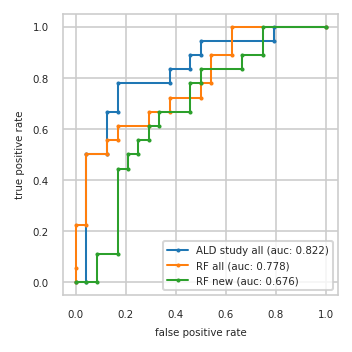

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.042 0.000  0.000 0.056  0.042 0.000
2          0.042 0.500  0.000 0.222  0.083 0.000
3          0.125 0.500  0.042 0.222  0.083 0.111
4          0.125 0.667  0.042 0.500  0.167 0.111
5          0.167 0.667  0.125 0.500  0.167 0.444
6          0.167 0.778  0.125 0.556  0.208 0.444
7          0.375 0.778  0.167 0.556  0.208 0.500
8          0.375 0.833  0.167 0.611  0.250 0.500
9          0.458 0.833  0.292 0.611  0.250 0.556
10         0.458 0.889  0.292 0.667  0.292 0.556
11         0.500 0.889  0.375 0.667  0.292 0.611
12         0.500 0.944  0.375 0.722  0.333 0.611
13         0.792 0.944  0.500 0.722  0.333 0.667
14         0.792 1.000  0.500 0.778  0.458 0.667
15         1.000 1.000  0.542 0.778  0.458 0.778
16           NaN   NaN  0.542 0.889  0.500 0.778
17           NaN   NaN  0.625 0.889  0.500 0.833
18           NaN   NaN  0.625 1.000  0.667 0.833
19           NaN   NaN  1.000 1.000  0.667 0.889
20           NaN   NaN    NaN   NaN  0.750 0.889
21           NaN   NaN    NaN   NaN  0.750 1.000
22           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,Q14894
1,A0A087X136;P51801,P60709;P63261,E5RJY1;E7ESM1;Q92597;Q92597-2;Q92597-3
2,G3V4U0;G3XA98;Q9UBX5,F8WE04;P04792,P51688
3,Q99983,C9JIZ6;P07602;P07602-2;P07602-3,P31321
4,P61981,P10636-2;P10636-6,Q96GD0
5,P04075,P04075,A0A0J9YW36;Q9NZ72;Q9NZ72-2
6,P14174,P14174,P31150
7,Q9Y2T3;Q9Y2T3-3,P61981,E9PK25;G3V1A4;P23528
8,P05413;S4R371,P25189;P25189-2,None


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


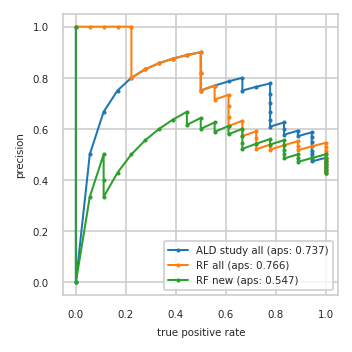

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.472 0.944     0.500 1.000     0.500 1.000
7          0.486 0.944     0.514 1.000     0.486 0.944
8          0.500 0.944     0.529 1.000     0.471 0.889
9          0.515 0.944     0.545 1.000     0.485 0.889
10         0.531 0.944     0.531 0.944     0.500 0.889
11         0.548 0.944     0.516 0.889     0.484 0.833
12         0.567 0.944     0.533 0.889     0.500 0.833
13         0.586 0.944     0.552 0.889     0.517 0.833
14         0.571 0.889     0.536 0.833     0.536 0.833
15         0.593 0.889     0.519 0.778     0.556 0.833
16         0.577 0.833     0.538 0.778     0.538 0.778
17         0.600 0.833     0.520 0.722     0.560 0.778
18         0.625 0.833     0.542 0.722     0.542 0.722
19         0.609 0.778     0.565 0.722     0.522 0.667
20         0.636 0.778     0.591 0.722     0.545 0.667
21         0.667 0.778     0.571 0.667     0.571 0.667
22         0.700 0.778     0.600 0.667     0.600 0.667
23         0.737 0.778     0.632 0.667     0.579 0.611
24         0.778 0.778     0.611 0.611     0.611 0.611
25         0.765 0.722     0.647 0.611     0.588 0.556
26         0.750 0.667     0.688 0.611     0.625 0.556
27         0.800 0.667     0.733 0.611     0.600 0.500
28         0.786 0.611     0.714 0.556     0.643 0.500
29         0.769 0.556     0.769 0.556     0.615 0.444
30         0.750 0.500     0.750 0.500     0.667 0.444
31         0.818 0.500     0.818 0.500     0.636 0.389
32         0.900 0.500     0.900 0.500     0.600 0.333
33         0.889 0.444     0.889 0.444     0.556 0.278
34         0.875 0.389     0.875 0.389     0.500 0.222
35         0.857 0.333     0.857 0.333     0.429 0.167
36         0.833 0.278     0.833 0.278     0.333 0.111
37         0.800 0.222     0.800 0.222     0.400 0.111
38         0.750 0.167     1.000 0.222     0.500 0.111
39         0.667 0.111     1.000 0.167     0.333 0.056
40         0.500 0.056     1.000 0.111     0.000 0.000
41         0.000 0.000     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


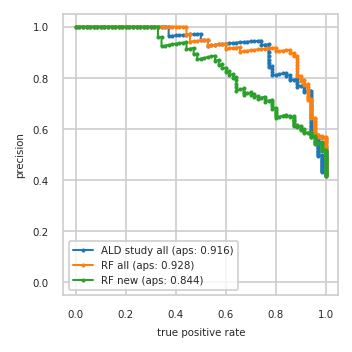

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


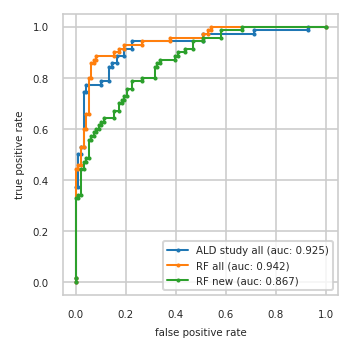

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}